In [2]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import time


from torch.autograd import Function

from itertools import product
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import copy
import json
from datetime import datetime

from pyepo.model.opt import optModel


sys.path.insert(0, 'E:\\User\\Stevens\\Code\\The Paper\\algorithm')

from myutil import *
from features import get_all_features
# Suppress warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



Auto-Sklearn cannot be imported.
cuda


In [3]:
alpha, Q = 2, 200

df = pd.read_csv('data/data.csv')
df = df.sample(n=2000, random_state=42)

In [4]:
columns_to_keep = [
    'risk_score_t', 'program_enrolled_t', 'cost_t', 'cost_avoidable_t', 'race', 'dem_female', 'gagne_sum_tm1', 'gagne_sum_t', 
    'risk_score_percentile', 'screening_eligible', 'avoidable_cost_mapped', 'propensity_score', 'g_binary', 
    'g_continuous', 'utility_binary', 'utility_continuous'
]
# for race 0 is white, 1 is black
df_stat = df[columns_to_keep]
df_feature = df[[col for col in df.columns if col not in columns_to_keep]]

# Replace all values less than 0.1 with 0.1
# Define input variables for DFL
feats = df_feature[get_all_features(df_feature)].values
risk = df_stat['risk_score_t'].values.clip(0.001)
gainF = df_stat['g_continuous'].values.clip(0.1)
decision = df_stat['propensity_score'].values
cost = np.ones(risk.shape)
race = df_stat['race'].values

# Transform the features
scaler = StandardScaler()
feats = scaler.fit_transform(feats)

# Train-test split
feats_train, feats_test, gainF_train, gainF_test, risk_train, risk_test, cost_train, cost_test, race_train, race_test = train_test_split(
    feats, gainF, risk, cost, race, test_size=0.5, random_state=42
)

print(f"Train size: {feats_train.shape}")
print(f"Test size: {feats_test.shape}")

def AlphaFairness(util,alpha):
    util = util.detach().cpu().numpy() if isinstance(util, torch.Tensor) else util

    if alpha == 1:
        return np.sum(np.log(util))
    elif alpha == 0:
        return np.sum(util)
    elif alpha == 'inf':
        return np.min(util)
    else:
        return np.sum(util**(1-alpha)/(1-alpha))


Train size: (1000, 147)
Test size: (1000, 147)


In [5]:
class AlphaFairModel(optModel):
    def __init__(self, alpha=alpha, N=None, Q=Q):
        self.alpha = alpha
        self.N = N
        self.Q = Q
        self.cost = None
        self.gainF = None  # Separate gain factor
        self.risk = None   # Separate risk
        self._problem = None
        self.d = None
        self.t = None
        super().__init__()
        
    def _getModel(self):
        if self.N is None:
            raise ValueError("Model size N must be set before initialization")
            
        self.d = cp.Variable(self.N, nonneg=True)
        model_vars = {"d": self.d}
        
        if self.alpha == 'inf':
            self.t = cp.Variable()
            model_vars["t"] = self.t
            
        return None, model_vars
    
    def setObj(self, risk, gainF, cost):
        if len(risk) != self.N or len(gainF) != self.N:
            raise ValueError(f"Risk and gainF lengths must match N={self.N}")
            
        if isinstance(risk, np.ndarray):
            risk = risk.flatten()
        if isinstance(gainF, np.ndarray):
            gainF = gainF.flatten()
            
        self.risk = risk
        self.gainF = gainF
            
        # Calculate utilities with separate risk and gainF
        utils = cp.multiply(cp.multiply(self.gainF, self.risk), self.d)
        
        constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(cost, self.d)) <= self.Q
        ]
        
        if self.alpha == 0:
            objective = cp.Maximize(cp.sum(utils))
        elif self.alpha == 1:
            objective = cp.Maximize(cp.sum(cp.log(utils)))
        elif self.alpha == 'inf':
            objective = cp.Maximize(self.t)
            constraints.append(utils >= self.t)
        else:
            objective = cp.Maximize(cp.sum(cp.power(utils, 1-self.alpha))/(1-self.alpha))
            
        self._problem = cp.Problem(objective, constraints)
    
    def solve(self):
        if self._problem is None:
            raise ValueError("Must call setObj before solving")
            
        try:
            self._problem.solve(solver=cp.MOSEK, verbose=False, 
                              warm_start=True, 
                              mosek_params={'MSK_IPAR_LOG': 1})
        except Exception as e:
            print(f"Optimization failed: {str(e)}")
            return np.zeros(self.N), 0.0
            
        if self._problem.status not in ["optimal", "optimal_inaccurate"]:
            print(f"Warning: Problem status is {self._problem.status}")
            return np.zeros(self.N), 0.0
            
        optimal_decision = self.d.value
        
        # Calculate optimal value using separate risk and gainF
        utils = optimal_decision * self.risk * self.gainF
        if self.alpha == 1:
            optimal_value = np.sum(np.log(utils))
        elif self.alpha == 0:
            optimal_value = np.sum(utils)
        elif self.alpha == 'inf':
            optimal_value = np.min(utils)
        else:
            optimal_value = np.sum(utils**(1-self.alpha))/(1-self.alpha)
            
        return optimal_decision, optimal_value
  

In [6]:
def solve_closed_form(g, r, c, alpha=alpha, Q=Q):

    g = g.detach().cpu().numpy() if isinstance(g, torch.Tensor) else g
    r = r.detach().cpu().numpy() if isinstance(r, torch.Tensor) else r
    c = c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else c

    if c.shape != r.shape or c.shape != g.shape:
        raise ValueError("c, r, and g must have the same shape.")
    if np.any(c <= 0):
        raise ValueError("All cost values must be positive.")
    if np.any(r <= 0):
        raise ValueError("All risk values must be positive.")
    if np.any(g <= 0):
        raise ValueError("All gain factors must be positive.")
    
    n = len(c)
    utility = r * g
    
    if alpha == 0:
        ratios = utility / c
        sorted_indices = np.argsort(-ratios)  # Descending order
        d_star_closed = np.zeros(n)
        d_star_closed[sorted_indices[0]] = Q / c[sorted_indices[0]]
        
    elif alpha == 1:
        d_star_closed = Q / (n * c)
    
    elif alpha == 'inf':
        d_star_closed = (Q * c) / (utility * np.sum(c * c / utility))
        
    else:
        if alpha <= 0:
            raise ValueError("Alpha must be positive for general case.")
        #
        # d_i* = (c_i^(-1/alpha) * (r_i*g_i)^(1/alpha - 1) * Q) / sum_j(c_j^(-1/alpha) * (r_j*g_j)^(1/alpha - 1))
        
        numerator = np.power(c, -1/alpha) * np.power(utility, 1/alpha - 1)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            raise ValueError("Denominator is zero in closed-form solution.")
            
        d_star_closed = (numerator / denominator) * Q
    
    # if not np.isclose(np.sum(c * d_star_closed), Q, rtol=1e-5):
    #     raise ValueError("Solution does not satisfy budget constraint.")
        
    sol, obj = d_star_closed, AlphaFairness(d_star_closed*g*r, alpha)

    return sol, obj


In [7]:
def compute_gradient_closed_form(g, r, c, alpha, Q):
    """
    Compute the analytical gradient of the optimal solution with respect to r.

    This function computes the gradient matrix where each element (i, k) is the partial derivative
    of d_i* with respect to r_k.

    Parameters:
    - g (np.ndarray): Gain factors (g_i), shape (n,)
    - r (np.ndarray): Risk values (r_i), shape (n,)
    - c (np.ndarray): Cost values (c_i), shape (n,)
    - alpha (float or str): Fairness parameter. Can be 0, 1, 'inf', or a positive real number.
    - Q (float): Total budget.

    Returns:
    - gradient (np.ndarray): Gradient matrix of shape (n, n)
    """
    if alpha == 0:
        # Utilitarian case: Gradient is undefined or zero
        # Since allocation is discrete, gradients are effectively zero
        return np.zeros((len(c), len(c)))

    elif alpha == 1:
        # Nash welfare case: Gradient is zero
        return np.zeros((len(c), len(c)))

    elif alpha == 'inf':
        # Maximin case
        n = len(c)
        utility = r * g  # Shape: (n,)
        S = np.sum(c**2 / utility)  # Scalar

        # Compute d_star
        d_star, _ = solve_closed_form(g,r,c, alpha='inf', Q=Q)  # Shape: (n,)

        # Initialize gradient matrix
        gradient = np.zeros((n, n))

        for i in range(n):
            for k in range(n):
                if i == k:
                    # ∂d_i*/∂r_i = -d_i*/r_i - (d_i* * c_i) / (r_i * g_i * S)
                    gradient[i, k] = -d_star[i] / r[i] - (d_star[i] * c[i]) / (r[i] * g[i] * S)
                else:
                    # ∂d_i*/∂r_k = (d_i* * c_k^2) / (c_i * r_k^2 * g_k * S)
                    gradient[i, k] = (d_star[i] * c[k]**2) / (c[i] * r[k]**2 * g[k] * S)
        return gradient

    else:
        # General alpha case
        if not isinstance(alpha, (int, float)):
            raise TypeError("Alpha must be a positive real number, 0, 1, or 'inf'.")
        if alpha <= 0:
            raise ValueError("Alpha must be positive for gradient computation.")

        # Compute the optimal decision variables
        d_star, _ = solve_closed_form(g, r, c, alpha, Q)  # Shape: (n,)

        # Compute the term (1/alpha - 1) * g / r
        term = (1.0 / alpha - 1.0) * g / r  # Shape: (n,)

        # Compute the outer product for off-diagonal elements
        # Each element (i, k) = -d_star[i] * d_star[k] * term[k] / Q
        gradient = -np.outer(d_star, d_star * term) / Q  # Shape: (n, n)

        # Compute the diagonal elements
        # Each diagonal element (i, i) = d_star[i] * term[i] * (1 - d_star[i]/Q)
        diag_elements = d_star * term * (1 - d_star / Q)  # Shape: (n,)

        # Set the diagonal elements
        np.fill_diagonal(gradient, diag_elements)

        return gradient

In [8]:
def solve_optimization(gainF, risk, cost, alpha, Q):
    # Flatten input arrays

    # if any of the inputs are tensor, convert to numpy array
    gainF = gainF.detach().cpu().numpy() if isinstance(gainF, torch.Tensor) else gainF
    risk = risk.detach().cpu().numpy() if isinstance(risk, torch.Tensor) else risk
    cost = cost.detach().cpu().numpy() if isinstance(cost, torch.Tensor) else cost


    risk = risk.clip(min=0.001)
    gainF, risk, cost = gainF.flatten(), risk.flatten(), cost.flatten()
    d = cp.Variable(risk.shape, nonneg=True)

    # raise error if dimensions do not match
    if gainF.shape != risk.shape or risk.shape != cost.shape:
        raise ValueError("Dimensions of gainF, risk, and cost do not match")
    
    utils = cp.multiply(cp.multiply(gainF, risk), d)
    
    if alpha == 'inf':
        # Maximin formulation
        t = cp.Variable()  # auxiliary variable for minimum utility
        objective = cp.Maximize(t)
        constraints = [
            d >= 0,
            # d <= 1,
            cp.sum(cost * d) <= Q,
            utils >= t  # t is the minimum utility
        ]
    elif alpha == 1:
        # Nash welfare (alpha = 1)
        objective = cp.Maximize(cp.sum(cp.log(utils)))
        constraints = [
            d >= 0,
            # d <= 1,
            cp.sum(cost * d) <= Q
        ]
    elif alpha == 0:
        # Utilitarian welfare (alpha = 0)
        objective = cp.Maximize(cp.sum(utils))
        constraints = [
            d >= 0,
            # d <= 1,
            cp.sum(cost * d) <= Q
        ]
    else:
        # General alpha-fairness
        objective = cp.Maximize(cp.sum(cp.power(utils, 1 - alpha)) / (1 - alpha) if alpha != 0 else cp.sum(utils))
        constraints = [
            d >= 0,
            # d <= 1,
            cp.sum(cost * d) <= Q
        ]
    
    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.MOSEK, verbose=False, warm_start=True, mosek_params={'MSK_IPAR_LOG': 1})
    
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError(f"Optimization failed with status {problem.status}")

    
    optimal_decision = d.value
    optimal_value = AlphaFairness(optimal_decision * gainF * risk, alpha)
    
    return optimal_decision, optimal_value


In [9]:
def visLearningCurve(loss_log, loss_log_regret, mse_loss_log, fairness_log=None):
    if fairness_log is not None:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 4))
    else:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    # Plot original loss log
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Training Loss Curve", fontsize=16)
    ax1.grid(True, alpha=0.3)

    # Plot regret log
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve (Test Regret)", fontsize=16)
    ax2.grid(True, alpha=0.3)

    # Plot MSE loss log
    ax3.plot(mse_loss_log, color="orange", lw=2)
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title("Learning Curve (MSE Loss)", fontsize=16)
    ax3.grid(True, alpha=0.3)

    # Plot fairness log if provided
    if fairness_log is not None:
        ax4.plot(fairness_log, color="green", lw=2)
        ax4.tick_params(axis="both", which="major", labelsize=12)
        ax4.set_xlabel("Iters", fontsize=16)
        ax4.set_ylabel("Fairness", fontsize=16)
        ax4.set_title("Learning Curve (Fairness)", fontsize=16)
        ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [10]:
class optDataset(Dataset):
    def __init__(self, optmodel, feats, risk, gainF, cost, race):
        self.feats = torch.from_numpy(feats).float()
        self.risk = torch.from_numpy(risk).float()
        self.gainF = torch.from_numpy(gainF).float()
        self.cost = torch.from_numpy(cost).float()
        self.race = torch.from_numpy(race).float()

        # Solve for w*, z* using separate risk and gainF
        self.opt_model = copy.deepcopy(optmodel)  # Ensure a separate instance
        self.w_star, self.z_star = self.opt_model(self.risk, self.gainF, self.cost, alpha=alpha, Q=Q)

        self.w_star = torch.tensor(self.w_star, dtype=torch.float)
        self.z_star = torch.tensor(self.z_star, dtype=torch.float)

    def __len__(self):
        return len(self.feats)

    def __getitem__(self, idx):
        return self.feats, self.risk, self.gainF, self.cost, self.race, self.w_star, self.z_star


In [11]:
import torch.nn as nn

class CostPredictor(nn.Module):
    """
    Takes feats of shape (N, d_feat) => outputs c_hat of shape (N,)
    This is a small MLP row-by-row, returning an (N,) vector.
    """
    def __init__(self, d_feat):
        super().__init__()
        self.hidden = nn.Linear(d_feat, 64)  
        self.relu = nn.ReLU()
        self.out = nn.Linear(64, 1)
        self.softplus = nn.Softplus()

    def forward(self, x):
        # x shape: (N, d_feat)
        # We produce shape: (N,). We can do it in a batch approach:
        h = self.hidden(x)   # shape (N,16)
        r = self.relu(h)
        out = self.out(r)    # shape (N,1)
        return self.softplus(out).squeeze(-1)  # shape (N,)


In [12]:
# setup dataset and dataloader
optmodel = solve_closed_form # or solve_optimization
# Create datasets
dataset_train = optDataset(optmodel, feats_train, risk_train, gainF_train, cost_train, race_train)
dataset_test = optDataset(optmodel, feats_test, risk_test, gainF_test, cost_test, race_test)

# Create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [13]:
class FairRiskPredictor(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.1):
        super().__init__()
        self.model = nn.Sequential(
            # First layer with batch normalization
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Second layer with batch normalization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Third layer with batch normalization
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            # Output layer
            nn.Linear(32, 1),
            nn.Softplus()
        )
            
        # Initialize weights using He initialization
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                    
    def forward(self, x):
        return self.model(x).squeeze(-1)
    
# init this model once and save the weights for later use
# predmodel = FairRiskPredictor(feats_train.shape[1])
# predmodel.to(device)
# # save without training
# torch.save(predmodel.state_dict(), 'predmodel.pth')

# load the model
predmodel = FairRiskPredictor(feats_train.shape[1])
predmodel.load_state_dict(torch.load('predmodel.pth'))
predmodel.to(device)

FairRiskPredictor(
  (model): Sequential(
    (0): Linear(in_features=147, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Softplus(beta=1, threshold=20)
  )
)

In [14]:
def regret(predmodel, optmodel, dataloader, alpha=alpha, Q=Q):
    predmodel.eval()
    feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(dataloader))

    if torch.cuda.is_available():
        feats, risk, gainF, cost, race, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), race.cuda(), opt_sol.cuda(), opt_val.cuda()

    # predict new rg
    with torch.no_grad():
        pred_risk = predmodel(feats)


    risk = risk.detach().to('cpu').numpy()
    pred_risk = pred_risk.detach().to('cpu').numpy()
    pred_risk = pred_risk.clip(min=0.001)

    gainF = gainF.detach().to('cpu').numpy()
    cost = cost.detach().to('cpu').numpy()

    pred_sol, _ = optmodel(gainF, pred_risk, cost, alpha, Q)
        
    pred_obj = AlphaFairness(gainF * risk * pred_sol, alpha)


    normalized_regret = (opt_val - pred_obj) / (abs(opt_val) + 1e-7)

    return normalized_regret

In [15]:
regret_on_test = regret(predmodel, solve_closed_form, dataloader_test, alpha, Q)
print(f"Regret on test: {regret_on_test.item():0.2f}")

Regret on test: 14.69


In [16]:
# group0_mask = (race == 0)
# group1_mask = (race == 1)
# pred_risk = predmodel(torch.tensor(feats).float().to(device)).detach().to('cpu').numpy()
# pred_risk = pred_risk.clip(min=0.001)

# pred_sol = solve_closed_form(gainF, pred_risk, cost, alpha, Q)

In [17]:
class FairRegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, gainF, pred_r, true_r, true_obj, Q, alpha, race, lambda_fairness, grad_method):
        ctx.grad_method = grad_method
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        gainF_np = gainF.detach().cpu().numpy()
        
        # Calculate regret losses
        for i in range(batch_size):
            sol, _ = optmodel(gainF_np[i], pred_r_np[i], cost_np[i], alpha, Q)
            obj = AlphaFairness(gainF_np[i] * true_r_np[i] * sol, alpha)
            losses[i] = true_obj[i] - obj
        
        # Calculate fairness loss
        group0_mask = (race == 0)
        group1_mask = (race == 1)
        group0_preds = pred_r[group0_mask]
        group1_preds = pred_r[group1_mask]
        group0_mean = group0_preds.mean() if len(group0_preds) > 0 else 0
        group1_mean = group1_preds.mean() if len(group1_preds) > 0 else 0
        fairness_loss = lambda_fairness * torch.abs(group0_mean - group1_mean)
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(gainF, pred_r, true_r, cost, true_obj, race)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.lambda_fairness = lambda_fairness
        ctx.losses = losses
        ctx.group0_mean = group0_mean
        ctx.group1_mean = group1_mean
        ctx.n0 = group0_mask.sum()
        ctx.n1 = group1_mask.sum()

        total_loss = losses.mean() + fairness_loss
        return total_loss.to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):
        gainF, pred_r, true_r, cost, true_obj, race = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha
        lambda_fairness = ctx.lambda_fairness
        group0_mean = ctx.group0_mean
        group1_mean = ctx.group1_mean
        n0 = ctx.n0
        n1 = ctx.n1
        grad_method = ctx.grad_method
        
        # Original regret gradient
        grad_l_d = (true_r * gainF) ** (1 - alpha) * pred_r ** (-alpha)

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        epsilon = 1e-5

        for i in range(batch_size):
            # Original gradient computation
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()
            gainF_np = gainF[i].detach().cpu().numpy()


            if grad_method == 'closed_form':
                closed_grad_d_r = compute_gradient_closed_form(gainF[i].detach().cpu().numpy(), pred_r_np, cost_np, alpha, Q)
                closed_grad_d_r = torch.tensor(closed_grad_d_r, device=pred_r.device, requires_grad=True)
                grad_l_d_i = -torch.tensor(grad_l_d[i], device=pred_r.device, requires_grad=True)
                grad_pred_r[i] = grad_l_d_i @ closed_grad_d_r

            elif grad_method == 'finite_difference':
                # Finite difference gradient
                grad_l_d_i = -torch.tensor(grad_l_d[i], device=pred_r.device, requires_grad=True)
                for j in range(len(pred_r_np)):
                    # Perturb the j-th element
                    perturbed_pred_r_plus = np.copy(pred_r_np)
                    perturbed_pred_r_minus = np.copy(pred_r_np)
                    perturbed_pred_r_plus[j] += epsilon
                    perturbed_pred_r_minus[j] -= epsilon
            
                    sol_plus, obj_plus = optmodel(gainF_np, perturbed_pred_r_plus, cost_np, alpha, Q)
                    sol_minus, obj_minus = optmodel(gainF_np, perturbed_pred_r_minus, cost_np, alpha, Q)

                    loss_plus = true_obj[i] - obj_plus
                    loss_minus = true_obj[i] - obj_minus

                    grad_pred_r[i][j] = (loss_plus - loss_minus) / (2 * epsilon)
            else:
                raise NotImplementedError(f"Gradient method {grad_method} not implemented.")

            # Add fairness gradient - handling race array
            if group0_mean != group1_mean:  # Only add fairness gradient if means are different
                # Get the race values for this batch item
                races_i = race[i]
                # For each element in the race array
                for j, race_val in enumerate(races_i):
                    if race_val == 0 and n0 > 0:
                        grad_pred_r[i][j] += lambda_fairness * torch.sign(group0_mean - group1_mean) / n0
                    elif race_val == 1 and n1 > 0:
                        grad_pred_r[i][j] -= lambda_fairness * torch.sign(group0_mean - group1_mean) / n1

        # grad_pred_r = grad_l_d @ closed_grad_d_r
        grad_pred_r = grad_output * grad_pred_r

        return None, None, None, grad_pred_r, None, None, None, None, None, None, None

class FairRegretLoss(nn.Module):
    def __init__(self, optmodel, Q=Q, alpha=alpha, lambda_fairness=1.0, grad_method='closed_form'):
        super(FairRegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha
        self.lambda_fairness = lambda_fairness
        self.grad_method = grad_method

    def forward(self, gainF, pred_r, true_r, cost, true_obj, race):
        return FairRegretLossFunction.apply(
            self.optmodel, gainF, cost, pred_r, true_r, true_obj, 
            self.Q, self.alpha, race, self.lambda_fairness, self.grad_method
        )

In [18]:
class FairMSELoss(nn.Module):
    def __init__(self, lambda_fairness=1.0):
        super(FairMSELoss, self).__init__()
        self.mse = nn.MSELoss()
        self.lambda_fairness = lambda_fairness

    def forward(self, pred, target, race):
        # Calculate MSE loss
        mse_loss = self.mse(pred, target)
        
        # Calculate fairness loss
        group0_mask = (race == 0)
        group1_mask = (race == 1)
        group0_preds = pred[group0_mask]
        group1_preds = pred[group1_mask]
        
        # Calculate group means
        group0_mean = group0_preds.mean() if len(group0_preds) > 0 else 0
        group1_mean = group1_preds.mean() if len(group1_preds) > 0 else 0
        
        # Compute fairness loss as absolute difference between group means
        fairness_loss = torch.abs(group0_mean - group1_mean)
        
        # Combine losses
        total_loss = mse_loss + self.lambda_fairness * fairness_loss
        
        return total_loss

In [19]:
def trainFairModel0(predmodel, optmodel, loader_train, loader_test, lambda_fairness=1.0, num_epochs=10, lr=1e-3):
    optimizer = optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()
    print('initial regret:', regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q))
    print("Training model...")
    fair_mse = FairMSELoss(lambda_fairness=lambda_fairness)
    predmodel.train()

    train_loss_log = []
    test_regret_log = []
    mse_loss_log = []
    fairness_log = []

    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()

        for data in loader_train:
            feats, risk, gainF, cost, race, opt_sol, opt_val = data
            if torch.cuda.is_available():
                feats, risk, gainF, cost, race, opt_sol, opt_val = (
                    feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), race.cuda(),
                    opt_sol.cuda(), opt_val.cuda()
                )
        # predict new risk
        pred_risk = predmodel(feats)
        pred_risk = pred_risk.clip(min=0.001)
        
        # Calculate losses
        loss_func = FairRegretLoss(optmodel, Q=Q, alpha=alpha, lambda_fairness=lambda_fairness)
        loss = loss_func(gainF, pred_risk, risk, cost, opt_val, race)
        mse_loss = mse_loss_func(pred_risk, risk)
        fair_mse_loss = fair_mse(pred_risk, risk, race)
        
        # Calculate fairness metric for logging
        group0_preds = pred_risk[race == 0]
        group1_preds = pred_risk[race == 1]
        fairness_metric = torch.abs(group0_preds.mean() - group1_preds.mean()).item() if len(group0_preds) > 0 and len(group1_preds) > 0 else 0
        
        optimizer.zero_grad()
        fair_mse.backward()
        optimizer.step()

        tock = time.time()
        elapsed += tock - tick
        train_loss_log.append(loss.item())
        mse_loss_log.append(mse_loss.item())
        fairness_log.append(fairness_metric)

        test_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
        test_regret_log.append(test_regret)
        print(f"Epoch {epoch + 1:2}, MSE:{mse_loss.item():.4f}, Loss:{loss.item():9.4f}, "
                f"Fairness:{fairness_metric:.4f}, Regret:{float(test_regret) * 100:7.4f}%, "
                f"Elapsed:{elapsed:.2f}s")

    predmodel.eval()
    return test_regret_log, train_loss_log, mse_loss_log, fairness_log

In [20]:
def trainFairModel(predmodel, optmodel, loader_train, loader_test, lambda_fairness, num_epochs=10, lr=1e-3,
                    alpha=alpha, Q=Q, dfl=True, grad_method='closed_form'):
   
    optimizer = torch.optim.Adam(predmodel.parameters(), lr=lr)
    loss_func = FairRegretLoss(optmodel, Q=Q, alpha=alpha, lambda_fairness=lambda_fairness, 
                               grad_method=grad_method)

    fair_mse_loss_func = FairMSELoss(lambda_fairness=lambda_fairness)
    mse_loss_func = nn.MSELoss()

    init_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
    print(f'Regret on test set is: {float(init_regret):.4f}')
    print("Training model...")
    # Initialize logs
    train_loss_log = []
    test_regret_log = []
    test_mse_log = []
    test_fair_log = []
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()
        predmodel.train()
        feats, risk, gainF, cost, race, opt_sol, opt_val = next(iter(loader_train))
        if torch.cuda.is_available():
            feats, risk, gainF, cost, race, opt_sol, opt_val = (
                feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(),
                race.cuda(), opt_sol.cuda(), opt_val.cuda()
            )
        
        # Predict new risk
        pred_risk = predmodel(feats)
        pred_risk = pred_risk.clip(min=0.001)

        loss = loss_func(gainF, pred_risk, risk, cost, opt_val, race)
        # evaluate mse loss
        mse_loss = mse_loss_func(pred_risk, risk)
        fair_mse_loss = fair_mse_loss_func(pred_risk, risk, race)

        # Calculate fairness metric for logging
        group0_preds = pred_risk[race == 0]
        group1_preds = pred_risk[race == 1]
        fairness_metric = torch.abs(group0_preds.mean() - group1_preds.mean()).item() if len(group0_preds) > 0 and len(group1_preds) > 0 else 0
        

        optimizer.zero_grad()
        if dfl:
            loss.backward()
        else:
            fair_mse_loss.backward()

        optimizer.step()

        tock = time.time()
        elapsed += tock - tick
        train_loss_log.append(loss.item() if not isinstance(loss, torch.Tensor) else loss.detach().cpu().numpy())
        test_mse_log.append(mse_loss.item() if not isinstance(mse_loss, torch.Tensor) else mse_loss.detach().cpu().numpy())
        test_fair_log.append(fair_mse_loss.item() if not isinstance(fair_mse_loss, torch.Tensor) else fair_mse_loss.detach().cpu().numpy())

        test_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
        test_regret_log.append(test_regret)

        if epoch % 5 == 0:
            print(f"Epoch {epoch+1:2}, MSE:{mse_loss.item():.2f}, Loss:{loss.item():.2f}, "
                    f"Fairness Measure:{fairness_metric:.4f}, Regret:{float(test_regret):.2f}%, "
                    f"Elapsed:{elapsed:.2f}s")

    predmodel.eval()
    return test_regret_log, train_loss_log, test_mse_log, test_fair_log


## Fair Prediction Fair Optimization 
## 2-stage with fair regularized MSE Loss

Regret on test set is: 14.6894
Training model...
Epoch  1, MSE:41.46, Loss:103610.63, Fairness Measure:0.1204, Regret:11.73%, Elapsed:0.37s
Epoch  6, MSE:23.73, Loss:60583.11, Fairness Measure:0.4785, Regret:9.89%, Elapsed:1.74s
Epoch 11, MSE:21.57, Loss:57111.08, Fairness Measure:0.6829, Regret:9.99%, Elapsed:3.08s
Epoch 16, MSE:25.00, Loss:58768.68, Fairness Measure:0.8105, Regret:10.31%, Elapsed:4.43s


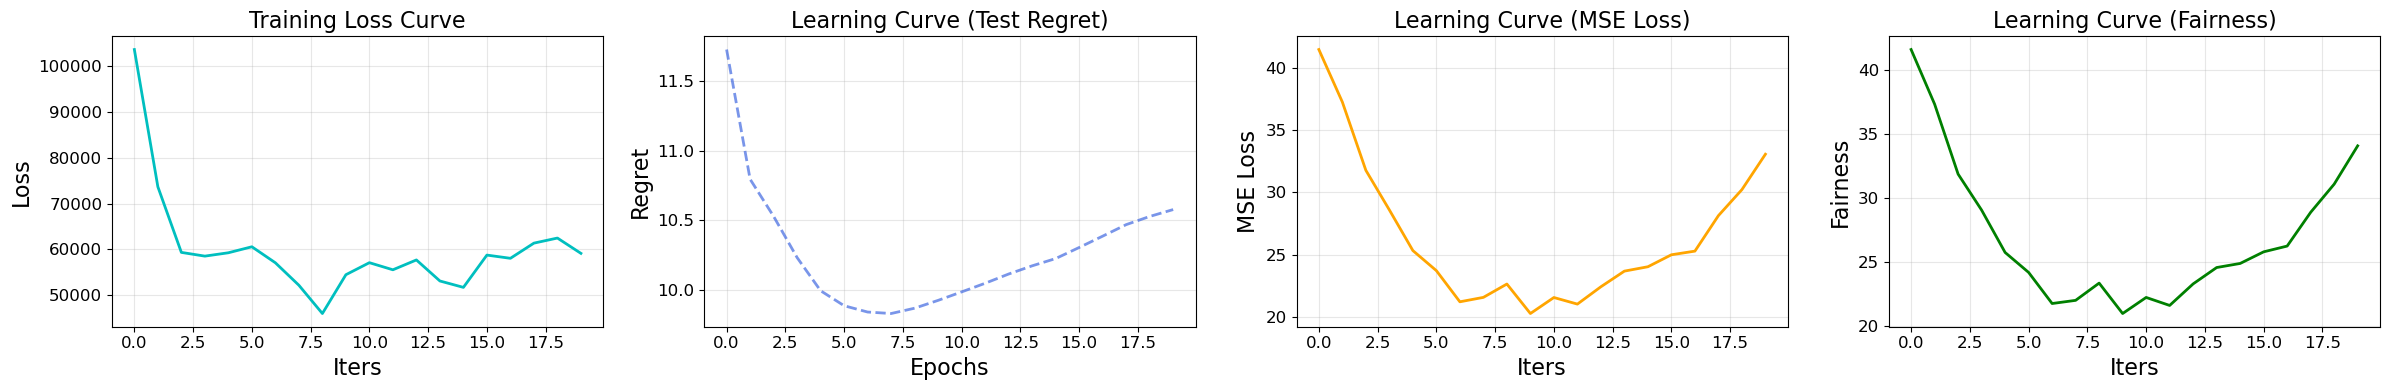

In [21]:
test_log, train_log, mse_loss_log, fair_log = trainFairModel(
    predmodel=predmodel,
    optmodel=solve_closed_form,
    loader_train=dataloader_train,  
    loader_test=dataloader_test,
    lambda_fairness=1,
    num_epochs=20,
    lr=2e-3,
    alpha=alpha,
    Q=Q,
    dfl=True,
    grad_method='finite_difference'
)

train_loss_log_values = [loss for loss in train_log]
test_regret_log_values = [regret.detach().cpu().numpy() for regret in test_log]
mse_loss_log_values = [loss for loss in mse_loss_log]
fairness_log_values = [fair for fair in fair_log]
visLearningCurve(
    train_loss_log_values,
    test_regret_log_values,
    mse_loss_log_values,
    fairness_log_values
)

In [22]:
raise ValueError("Stop here")

ValueError: Stop here

## 


Running experiment: lambda=0_dfl=False_grad=closed_form
Regret on test set is: 12.4761
Training model...
Epoch  1, MSE:42.34, Loss:69984.38, Fairness Measure:0.0006, Regret:12.40%, Elapsed:0.01s
Epoch  6, MSE:41.35, Loss:67760.42, Fairness Measure:0.0197, Regret:11.95%, Elapsed:0.04s
Epoch 11, MSE:39.21, Loss:63851.67, Fairness Measure:0.0735, Regret:11.15%, Elapsed:0.07s
Epoch 16, MSE:34.39, Loss:59111.57, Fairness Measure:0.2016, Regret:10.04%, Elapsed:0.12s

Results for lambda=0_dfl=False_grad=closed_form:


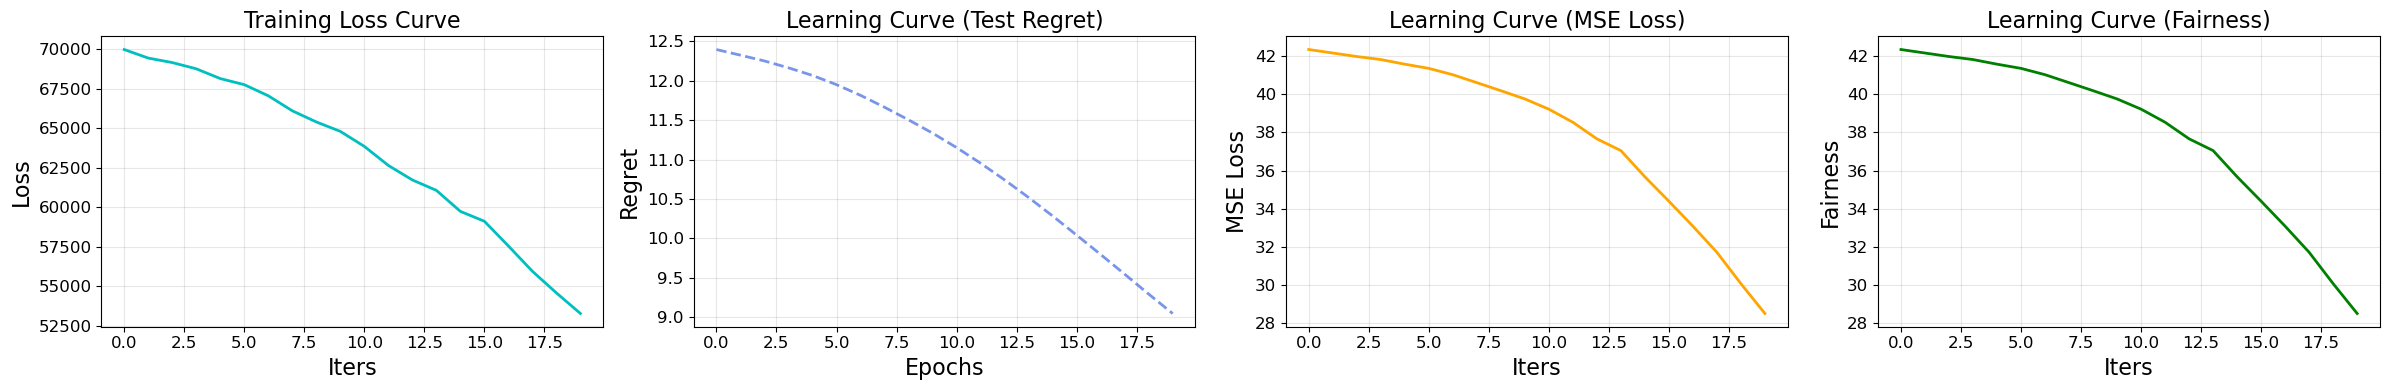


Running experiment: lambda=0_dfl=False_grad=finite_difference
Regret on test set is: 12.4022
Training model...
Epoch  1, MSE:42.49, Loss:411885.22, Fairness Measure:0.0014, Regret:12.28%, Elapsed:0.06s
Epoch  6, MSE:41.29, Loss:409646.06, Fairness Measure:0.0240, Regret:11.69%, Elapsed:0.70s
Epoch 11, MSE:38.99, Loss:406746.41, Fairness Measure:0.0571, Regret:10.80%, Elapsed:1.02s
Epoch 16, MSE:34.54, Loss:400987.00, Fairness Measure:0.1766, Regret:9.66%, Elapsed:1.40s

Results for lambda=0_dfl=False_grad=finite_difference:


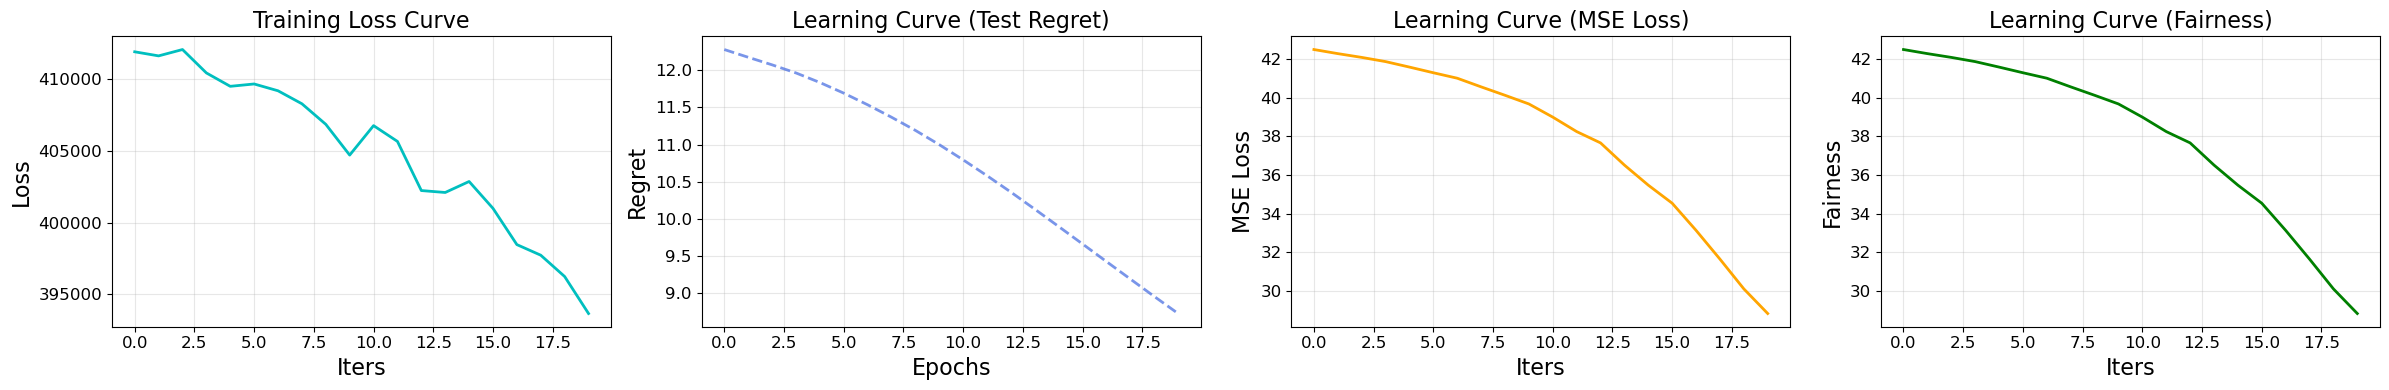


Running experiment: lambda=0_dfl=True_grad=closed_form
Regret on test set is: 12.4922
Training model...
Epoch  1, MSE:42.94, Loss:70057.78, Fairness Measure:0.0027, Regret:12.37%, Elapsed:0.20s
Epoch  6, MSE:42.54, Loss:66944.34, Fairness Measure:0.0111, Regret:11.79%, Elapsed:0.98s
Epoch 11, MSE:41.82, Loss:63464.53, Fairness Measure:0.0249, Regret:10.99%, Elapsed:1.70s
Epoch 16, MSE:40.50, Loss:57777.30, Fairness Measure:0.0618, Regret:9.79%, Elapsed:2.50s

Results for lambda=0_dfl=True_grad=closed_form:


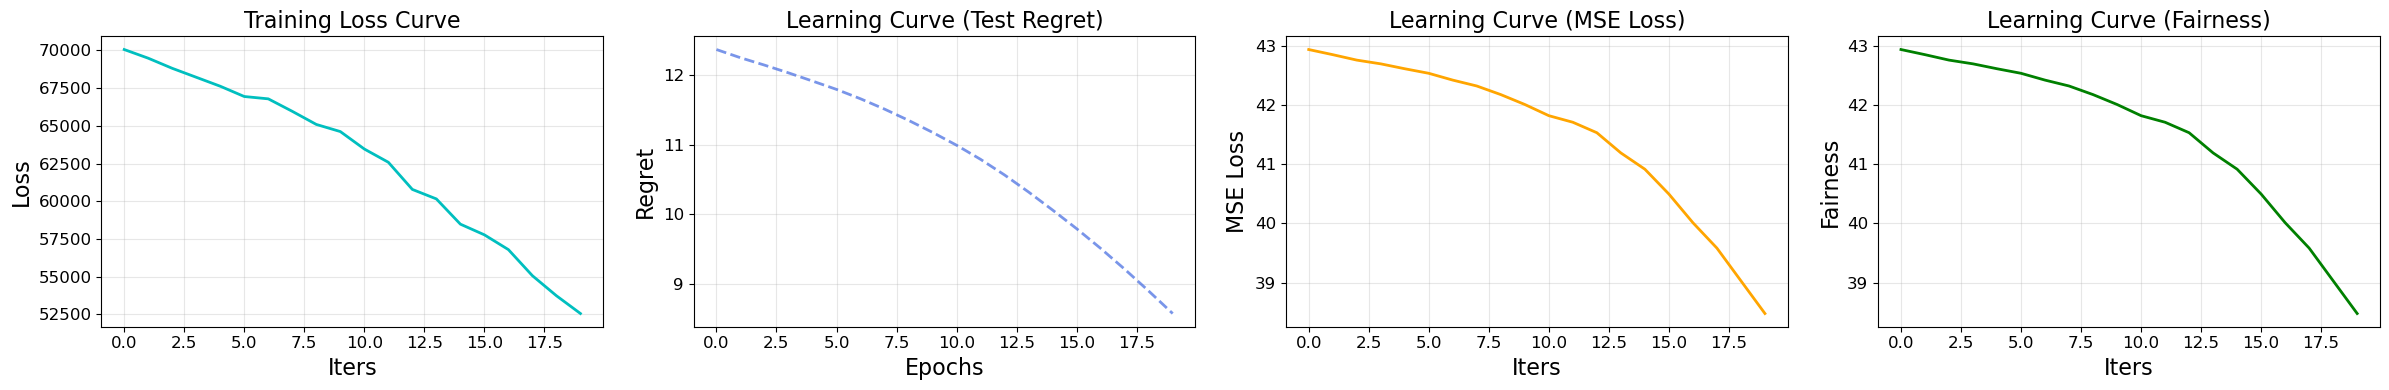


Running experiment: lambda=0_dfl=True_grad=finite_difference
Regret on test set is: 12.5389
Training model...


In [ ]:
def run_experiments(predmodel, dataloader_train, dataloader_test, alpha, Q):
    """
    Run experiments with different combinations of parameters.
    
    Parameters:
    -----------
    predmodel : model
        Prediction model to train
    dataloader_train : DataLoader
        Training data loader
    dataloader_test : DataLoader
        Test data loader
    alpha : float
        Alpha parameter for fairness calculation
    Q : tensor
        Q parameter for the model
    """
    # Define parameter combinations
    lambda_values = [0, 0.5, 1]
    dfl_values = [False, True]
    grad_methods = ['closed_form', 'finite_difference']
    
    # Fixed parameters
    num_epochs = 20
    lr = 1e-3
    
    # Store results for comparison
    all_results = {}
    
    for lambda_fair in lambda_values:
        for dfl in dfl_values:
            for grad_method in grad_methods:
                # Create experiment identifier
                exp_id = f'lambda={lambda_fair} dfl={dfl} grad={grad_method}'
                print(f"\nRunning experiment: {exp_id}")
                
                # Select appropriate solve function based on grad_method
                solve_function = solve_closed_form if grad_method == 'closed_form' else solve_optimization
                
                try:
                    # Reset model weights for fair comparison
                    predmodel.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
                    
                    # Run training
                    test_log, train_log, mse_loss_log, fair_log = trainFairModel(
                        predmodel=predmodel,
                        optmodel=solve_function,
                        loader_train=dataloader_train,
                        loader_test=dataloader_test,
                        lambda_fairness=lambda_fair,
                        num_epochs=num_epochs,
                        lr=lr,
                        alpha=alpha,
                        Q=Q,
                        dfl=dfl,
                        grad_method=grad_method
                    )
                    
                    # Process logs
                    train_loss_log_values = [loss for loss in train_log]
                    test_regret_log_values = [regret.detach().cpu().numpy() for regret in test_log]
                    mse_loss_log_values = [loss for loss in mse_loss_log]
                    fairness_log_values = [fair for fair in fair_log]
                    
                    # Store results
                    all_results[exp_id] = {
                        'train_loss': train_loss_log_values,
                        'test_regret': test_regret_log_values,
                        'mse_loss': mse_loss_log_values,
                        'fairness': fairness_log_values
                    }

                    # Visualize current experiment
                    print(f"\nResults for {exp_id}:")
                    visLearningCurve(
                        train_loss_log_values,
                        test_regret_log_values,
                        mse_loss_log_values,
                        fairness_log_values
                    )
                    
                except Exception as e:
                    print(f"Error in experiment {exp_id}: {str(e)}")
                    continue
    
    return all_results

def compare_experiments(all_results):
    """
    Create comparison plots for different experiments.
    
    Parameters:
    -----------
    all_results : dict
        Dictionary containing results from all experiments
    """
    metrics = ['train_loss', 'test_regret', 'mse_loss', 'fairness']
    
    for metric in metrics:
        plt.figure(figsize=(12, 6))
        for exp_id, results in all_results.items():
            plt.plot(results[metric], label=exp_id)
        
        plt.title(f'Comparison of {metric.replace("_", " ").title()}', fontsize=14)
        plt.xlabel('Iterations', fontsize=12)
        plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

results = run_experiments(predmodel, dataloader_train, dataloader_test, alpha, Q)
compare_experiments(results)

In [2265]:
raise ValueError("Stop here")

ValueError: Stop here

In [1460]:
class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, gainF, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        gainF_np = gainF.detach().cpu().numpy()
        
        for i in range(batch_size):
            sol, _ = solve_closed_form(gainF_np[i], pred_r_np[i], cost_np[i], alpha, Q)
            obj = AlphaFairness(gainF_np[i] * true_r_np[i] * sol, alpha)
            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(gainF, pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.losses = losses

        return losses.mean().to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):
        gainF, pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha
        method = ctx.method

        
        grad_l_d = (true_r * gainF) ** (1 - alpha) * pred_r ** (-alpha)
        # print("grad_l_d",grad_l_d)

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        epsilon = 1e-5

        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()

            # Analytical
            closed_grad_d_r = compute_gradient_closed_form(gainF[i].detach().cpu().numpy(), pred_r_np, cost_np, alpha, Q)
            print(closed_grad_d_r)
            # closed_grad_diag = np.sum(closed_grad_d_r, axis=1)
            gradient = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r_plus = np.copy(pred_r_np)
                perturbed_pred_r_minus = np.copy(pred_r_np)
                perturbed_pred_r_plus[j] += epsilon
                perturbed_pred_r_minus[j] -= epsilon
                
                # Compute loss with perturbed pred_r
                sol_plus, _ = solve_closed_form(gainF[i].detach().cpu().numpy(), perturbed_pred_r_plus, cost_np, alpha, Q)
                sol_minus, _ = solve_closed_form(gainF[i].detach().cpu().numpy(), perturbed_pred_r_minus, cost_np, alpha, Q)
                
                obj_perturbed_plus = AlphaFairness(gainF[i].detach().cpu().numpy() * true_r_np * sol_plus, alpha)
                obj_perturbed_minus = AlphaFairness(gainF[i].detach().cpu().numpy() * true_r_np * sol_minus, alpha)
                
                loss_perturbed_plus = true_obj[i].item() - obj_perturbed_plus
                loss_perturbed_minus = true_obj[i].item() - obj_perturbed_minus
                
                # Finite difference approximation
                gradient[j] = (loss_perturbed_plus - loss_perturbed_minus) / (2 * epsilon)
            closed_grad_d_r = torch.tensor(closed_grad_d_r, device=pred_r.device, requires_grad=True)
            grad_l_d = -torch.tensor(grad_l_d, device=pred_r.device, requires_grad=True)
            grad_pred_r =  grad_l_d @ closed_grad_d_r 
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, None, grad_pred_r, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q=Q, alpha=alpha):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, gainF, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, gainF, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


In [1461]:
def trainModel(predmodel, optmodel, loss_func, loader_train, loader_test, num_epochs=10, lr=1e-3):
    optimizer = optim.Adam(predmodel.parameters(), lr=lr)
    mse_loss_func = nn.MSELoss()
    print('inital regret:', regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q))
    print("Training model...")
    
    predmodel.train()

    train_loss_log = []
    test_regret_log = []
    mse_loss_log = []

    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()


        for data in loader_train:
            feats, risk, gainF, cost, opt_sol, opt_val = data
        if torch.cuda.is_available():
            feats, risk, gainF, cost, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), opt_sol.cuda(), opt_val.cuda()
        
        # predict new risk
        pred_risk = predmodel(feats)
        pred_risk = pred_risk.clip(min=0.001)
        loss_func = RegretLoss(optmodel, Q=Q, alpha=alpha)
        loss = loss_func(gainF, pred_risk, risk, cost, opt_val) 
        mse_loss = mse_loss_func(pred_risk, risk)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tock = time.time()
        elapsed += tock - tick
        train_loss_log.append(loss.item())
        mse_loss_log.append(mse_loss.item())

        test_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
        test_regret_log.append(test_regret)
        print(f"Epoch {epoch + 1:2}, MSE:{mse_loss.item():.4f} Loss: {loss.item():9.4f}, Regret: {float(test_regret) * 100:7.4f}%, Elapsed: {elapsed:.2f}s")

    predmodel.eval()
    return test_regret_log, train_loss_log, mse_loss_log

In [ ]:
import torch
from torch import nn
import numpy as np

class RegretLossFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, pred_risk, true_risk, gainF, cost, alpha, Q):
        """
        Forward pass computing regret loss with normalized inputs
        """
        # Ensure inputs are 2D
        if pred_risk.dim() == 1:
            pred_risk = pred_risk.unsqueeze(0)
            true_risk = true_risk.unsqueeze(0)
            gainF = gainF.unsqueeze(0)
            cost = cost.unsqueeze(0)
            
        batch_size, N = pred_risk.shape
        
        # Convert to numpy
        pred_risk_np = pred_risk.detach().cpu().numpy()
        true_risk_np = true_risk.detach().cpu().numpy()
        gainF_np = gainF.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        # Normalize predictions to be in similar range as true risk
        risk_scale = np.mean(true_risk_np) / np.mean(pred_risk_np)
        pred_risk_np = pred_risk_np * risk_scale
        
        regrets = np.zeros(batch_size)
        d_preds = []
        w_preds = []
        w_trues = []
        
        for i in range(batch_size):
            # Compute optimal decisions
            d_pred, _ = solve_closed_form(gainF_np[i], pred_risk_np[i], cost_np[i], alpha, Q)
            d_true, _ = solve_closed_form(gainF_np[i], true_risk_np[i], cost_np[i], alpha, Q)
            
            # Calculate utilities and welfare
            util_pred = gainF_np[i] * true_risk_np[i] * d_pred
            util_true = gainF_np[i] * true_risk_np[i] * d_true
            
            welfare_pred = AlphaFairness(util_pred, alpha)
            welfare_true = AlphaFairness(util_true, alpha)
            
            regrets[i] = welfare_true - welfare_pred
            d_preds.append(d_pred)
            w_preds.append(welfare_pred)
            w_trues.append(welfare_true)
        
        # Store values needed for backward pass
        ctx.save_for_backward(pred_risk, true_risk, gainF, cost)
        ctx.risk_scale = risk_scale
        ctx.alpha = alpha
        ctx.Q = Q
        ctx.d_preds = d_preds
        ctx.N = N
        
        return torch.tensor(regrets, dtype=torch.float32, device=pred_risk.device)
    
    @staticmethod
    def backward(ctx, grad_output):
        pred_risk, true_risk, gainF, cost = ctx.saved_tensors
        risk_scale = ctx.risk_scale
        alpha = ctx.alpha
        Q = ctx.Q
        d_preds = ctx.d_preds
        N = ctx.N
        batch_size = pred_risk.shape[0]
        
        # Convert to numpy
        pred_risk_np = pred_risk.detach().cpu().numpy()
        gainF_np = gainF.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        grad_pred_risk = np.zeros((batch_size, N))
        
        for i in range(batch_size):
            # Compute gradients with scaling
            scaled_pred_risk = pred_risk_np[i] * risk_scale
            jacobian = compute_gradient_closed_form(gainF_np[i], scaled_pred_risk, cost_np[i], alpha, Q)
            
            # Apply chain rule: include scaling factor in gradient
            grad_pred_risk[i] = -grad_output[i].item() * jacobian.sum(axis=0) * risk_scale
            
            # Scale gradients to prevent vanishing/exploding
            grad_norm = np.linalg.norm(grad_pred_risk[i])
            if grad_norm > 0:
                target_norm = 1.0  # Target gradient norm
                grad_pred_risk[i] = grad_pred_risk[i] * (target_norm / grad_norm)
        
        # Convert to tensor
        grad_pred_risk = torch.tensor(grad_pred_risk, dtype=torch.float32, device=pred_risk.device)
        
        return grad_pred_risk, None, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, alpha, Q):
        super().__init__()
        self.alpha = alpha
        self.Q = Q
        
    def forward(self, pred_risk, true_risk, gainF, cost):
        return RegretLossFunction.apply(pred_risk, true_risk, gainF, cost, self.alpha, self.Q)

In [ ]:
import time

def trainModel(predmodel, optmodel, loss_func, loader_train, loader_test, num_epochs=10, lr=1e-3):
    optimizer = optim.Adam(predmodel.parameters(), lr=lr)
    
    predmodel.train()

    train_loss_log = []
    test_regret_log = [regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)]
    mse_loss_log = []

    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()

        for data in loader_train:
            feats, risk, gainF, cost, opt_sol, opt_val = data
            if torch.cuda.is_available():
                feats, risk, gainF, cost, opt_sol, opt_val = feats.cuda(), risk.cuda(), gainF.cuda(), cost.cuda(), opt_sol.cuda(), opt_val.cuda()
            
            # predict new risk
            pred_risk = predmodel(feats)
            loss = loss_func(pred_risk, risk)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tock = time.time()
            elapsed += tock - tick
            train_loss_log.append(loss.item())

        test_regret = regret(predmodel, optmodel, loader_test, alpha=alpha, Q=Q)
        test_regret_log.append(test_regret)
        print(f"Epoch {epoch + 1:2},  Loss: {loss.item():9.4f}, Regret: {float(test_regret) * 100:7.4f}%, Elapsed: {elapsed:.2f}s")

    predmodel.eval()
    return test_regret_log, train_loss_log

In [ ]:
def train_with_regret(predmodel, optmodel, loader_train, loader_test, num_epochs=50, lr=1e-4, weight_decay=1e-5, alpha=alpha, Q=Q):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    predmodel.to(device)
    
    # Initialize optimizer with smaller learning rate and gradient clipping
    optimizer = optim.AdamW(predmodel.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = RegretLoss(alpha=alpha, Q=Q)
    
    train_loss_log = []
    test_regret_log = []
    best_regret = float('inf')
    best_model_state = None
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        predmodel.train()
        epoch_losses = []
        
        for feats, risk, gainF, cost, _, _ in loader_train:
            feats = feats.to(device)
            risk = risk.to(device)
            gainF = gainF.to(device)
            cost = cost.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            pred_risk = predmodel(feats)
            
            # Print prediction statistics
            print(f"\nPrediction stats:")
            print(f"pred_risk - Mean: {pred_risk.mean():.4f}, Min: {pred_risk.min():.4f}, Max: {pred_risk.max():.4f}")
            print(f"true_risk - Mean: {risk.mean():.4f}, Min: {risk.min():.4f}, Max: {risk.max():.4f}")
            
            # Calculate regret loss
            loss = criterion(pred_risk, risk, gainF, cost).mean()
            
            # Check for NaN loss
            if torch.isnan(loss):
                print("NaN loss detected!")
                continue
                
            # Backward pass with gradient clipping
            loss.backward()
            
            # Print gradient norms for debugging
            total_norm = 0.0
            for p in predmodel.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            print(f"Gradient norm before clipping: {total_norm:.4f}")
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(predmodel.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Ensure predictions stay positive
            with torch.no_grad():
                for p in predmodel.parameters():
                    if p.requires_grad:
                        p.data.clamp_(min=0.001)
            
            epoch_losses.append(loss.item())
        
        avg_train_loss = np.mean(epoch_losses)
        train_loss_log.append(avg_train_loss)
        
        # Evaluate
        predmodel.eval()
        with torch.no_grad():
            test_regret = regret(predmodel, solve_optimization, loader_test)
            test_regret_log.append(test_regret)
            
            # Early stopping logic
            if test_regret < best_regret:
                best_regret = test_regret
                best_model_state = predmodel.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break
        
        
        print(f"Epoch {epoch + 1}")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Test Regret: {float(test_regret):.4f}")
        print(f"Best Regret: {float(best_regret):.4f}")
    
    # Restore best model
    if best_model_state is not None:
        predmodel.load_state_dict(best_model_state)
    
    return train_loss_log, test_regret_log